# 2D Variational MD

This jupyter notebook contains the final code for the self consistent procedure for the first potential.

## Libraries

In [1]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Linrary for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

The following cell makes the fontsize of the plot a bit bigger.

In [2]:
plt.rcParams.update({'font.size': 16})

Run the following line without "#" in order to get the plots as windows in the browser (useful because it is possible to zoom the plots).

In [3]:
## Line to make plot in other windows of browser
#%matplotlib

I fix the random seed for the simulations.

In [4]:
## Seed used for the simulation
np.random.seed(42)

## Functions

In [5]:
# Parameters of the potentials
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

In [6]:
@njit(fastmath=True)
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 4.0/3.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - 4.0/3.0*np.exp(-(q[0]**2 + (q[1] + b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4 + (q[1] + a0)**4)
    return U

@njit(fastmath=True)
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-(x2+(q[1]+ b0)**2))
    e4 = np.exp(-((q[0] - x0)**2 + y2))
    e5 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -4.0/3.0*q[0]*e2 -4.0/3.0*q[0]*e3 - (q[0]-x0)*e4 - (q[0]+x0)*e5)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -4.0/3.0*(q[1] - b0)*e2 -4.0/3.0*(q[1] + b0)*e3 - q[1]*e4 - q[1]*e5)-4.0*w0*(q[1] - a0)**3-4.0*w0*(q[1] + a0)**3

    return np.array([fx, fy])

@njit(fastmath=True)
def state(q, R=0.2): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp1 = q[0]**2 + 1.1**2 + q[1]**2
    tmp2 = 2.0*1.1*q[0]
    if tmp1 - tmp2 < R**2:
        # Product state
        state = 1
    if tmp1 + tmp2 < R**2:
        # Reactant state
        state = -1
    return state

## First guess of the committor function: q increases linearly along x
# The committor starts from the inner edges of the states
@njit(fastmath=True)
def qLin(q, R=0.2):
    if q[0] <= R-1.1:
        return 0
    elif q[0] >= 1.1-R:
        return 1
    else:
        return q[0]/(2.0*(1.1-R))+0.5

#Gradient of the first committor guess
@njit(fastmath=True)
def dqLin(q, R=0.2):
    if q[0] < R-1.1 or q[0] > 1.1-R:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.1-R)), 0.0

# The committor starts from the outerr edges of the states
@njit(fastmath=True)
def qLin2(q, R=0.2):  
    if q[0] <= -R-1.1:
        return 0
    elif q[0] >= 1.1+R:
        return 1
    elif (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0
    elif (q[0] - 1.1)**2 + q[1]**2 <= R**2:
        return 1
    else:
        return q[0]/(2.0*(1.1+R))+0.5

@njit(fastmath=True)
def dqLin2(q, R=0.2):
    if q[0] < -R-1.1 or q[0] > 1.1+R or (q[0] - 1.1)**2 + q[1]**2 <= R**2 or (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.1+R)), 0.0
    
    
# The committor starts from the center of the states
@njit(fastmath=True)
def qLin3(q, R=0.2):
    if q[0] <= -1.1:
        return 0
    elif q[0] >= 1.1:
        return 1
    elif (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0
    elif (q[0] - 1.1)**2 + q[1]**2 <= R**2:
        return 1
    else:
        return q[0]/(2.0*1.1)+0.5

@njit(fastmath=True)
def dqLin3(q, R=0.2):
    if q[0] < -1.1 or q[0] > 1.1 or (q[0] - 1.1)**2 + q[1]**2 <= R**2 or (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*1.1), 0.0    
    
#Second guess of the committor function: q increases along a circle
@njit(fastmath=True)
def qCircle(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.1)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else: 
        return (theta - alpha)/(np.pi - alpha)

#Gradient of the second committor guess
@njit(fastmath=True)
def dqCircle(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.1)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]>0:
            return q[1]/(q[0]**2 + q[1]**2), -q[0]/(q[0]**2 + q[1]**2)
        else:
            return -q[1]/(q[0]**2 + q[1]**2), q[0]/(q[0]**2 + q[1]**2)
        
        
@njit(fastmath=True)
def qCircleU(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.1)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] < 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)

@njit(fastmath=True)
def dqCircleU(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.1)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1] > 0.0:
            return q[1]/(q[0]**2 + q[1]**2), -q[0]/(q[0]**2 + q[1]**2)
        else:
            return 0.0, 0.0            
                
@njit(fastmath=True)
def qCircleD(q, R=0.2):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.1)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] > 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)   
        
@njit(fastmath=True)
def dqCircleD(q, R=0.2):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.1)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]< 0.0:
            return -q[1]/(q[0]**2 + q[1]**2), q[0]/(q[0]**2 + q[1]**2)
        else:
            return 0.0, 0.0
        
# Third guess function: euclidian distance between the two states
@njit(fastmath=True)
def qDist(q, R=0.2):
    if (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.1)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.1)**2 + q[1]**2 >= (2.0*1.1-R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.1)**2 + q[1]**2)-R)/(2.0*(1.1-R))
        
@njit(fastmath=True)        
def dqDist(q, R=0.2):
    if (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.1)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.1)**2 + q[1]**2 >= (2.0*1.1+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.1)/(2.0*(1.1-R)*np.sqrt((q[0] - 1.1)**2 + q[1]**2)), -q[1]/(2.0*(1.1-R)*np.sqrt((q[0] - 1.1)**2 + q[1]**2))

@njit(fastmath=True)
def qDist2(q, R=0.2):
    if (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.1)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.1)**2 + q[1]**2 >= (2.0*1.1+R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.1)**2 + q[1]**2)-R)/(2.0*1.1)
        
@njit(fastmath=True)        
def dqDist2(q, R=0.2):
    if (q[0] + 1.1)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.1)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.1)**2 + q[1]**2 >= (2.0*1.1+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.1)/(2.0*1.1*np.sqrt((q[0] - 1.1)**2 + q[1]**2)), -q[1]/(2.0*1.1*np.sqrt((q[0] - 1.1)**2 + q[1]**2))
    
def comm_plot(Guess1, Guess2, c = [0.5, 0.5], R = 0.2):
    # Resolution of the plot
    dx, dy = 0.01, 0.01
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),slice(-1.5, 1.5 + dx, dx)]
    # Plot the committor
    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # Product state
            if (x[i,j] - 1.1)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            # Reactant state
            elif (x[i,j] + 1.1)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = c[0]*Guess1([x[i,j], y[i,j]], R=R) + c[1]*Guess2([x[i,j], y[i,j]], R=R)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # contours are *point* based plots, so convert our bound into point centers
    plt.figure()
    plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
    plt.colorbar()
    # Title and labels
    plt.title('Committor with coefficients '+str(c))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

def plot_prob_distr(trajectories, xedge, yedge, delta, ncontour):
    ## Density plot of how much time the system passes in a given point
    # Borders of the plot
    xedges = np.arange(xedge[0],xedge[1], delta).tolist()
    yedges = np.arange(yedge[0],yedge[1], delta).tolist()
    # Load the data
    x = trajectories[:,0]
    y = trajectories[:,1]
    # Create the histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
    H = H.T  # Let each row list bins with common y range.
    plt.figure()
    im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax = plt.gca()
    # colormap, colorbar, labels, ect.
    im.set_cmap('RdBu')
    # contour lines
    x = np.arange(xedge[0],xedge[1], 0.025)
    y = np.arange(yedge[0],yedge[1], 0.025)
    X, Y = np.meshgrid(x, y)
    # Identity matrix
    I = X*0+1
    # Probability of the 
    U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
    U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
    Z = np.exp(-KBT*(U1 + U2))
    CS = plt.contour(X, Y, Z, ncontour, colors='k')
    # labels and title
    plt.title("Sampling transition region")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    plt.show()    
    
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i,:])
        # Linear combination of committors
        z0 = Guess1(q[i,:], R)
        z1 = Guess2(q[i,:], R)
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1, dGy1 = dGuess1(q[i,:], R)
        dGx2, dGy2 = dGuess2(q[i,:], R)
        # Matrix M
        M[i,0,0] = dGx1**2 + dGy1**2
        M[i,1,0] = dGx2*dGx1+dGy2*dGy1
        M[i,0,1] = dGx1*dGx2+dGy1*dGy2
        M[i,1,1] = dGx2**2 + dGy2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*(c[0]*dGy1 + c[1]*dGy2)*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

def Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

def Self_consistent(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = cout[0,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

def comm_plot2(Guess1, Guess2, c = [np.sqrt(0.5), np.sqrt(0.5)], R = 0.2):
    # Resolution of the plot
    dx, dy = 0.01, 0.01
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 1.5 + dy, dy),slice(-1.5, 1.5 + dx, dx)]
    # Plot the committor
    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # Product state
            if (x[i,j] - 1.1)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            # Reactant state
            elif (x[i,j] + 1.1)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = c[0]**2*Guess1([x[i,j], y[i,j]], R=R) + c[1]**2*Guess2([x[i,j], y[i,j]], R=R)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # contours are *point* based plots, so convert our bound into point centers
    plt.figure()
    plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
    plt.colorbar()
    # Title and labels
    plt.title('Committor with coefficients '+str(c))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()
    
@njit(fastmath=True)
def LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, q0 = None, c = [np.sqrt(0.5), np.sqrt(0.5)], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    # Assign initial position to the border of the reactant state
    r = random.random_sample()
    # I just precompute the square of the coefficients to speed up the code
    c02 = c[0]**2
    c12 = c[1]**2
    if q0 is None:
        r = 2.0*random.random_sample()-1.0
        q[0,0] = -1.1+R*np.sqrt(1.0-r**2)+0.001
        q[0,1] = R*r
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:], R) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    z0 = Guess1(q[0,:], R)
    z1 = Guess2(q[0,:], R)
    zmax = c02*z0+c12*z1
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i,:])
        # Linear combination of committors
        z0 = Guess1(q[i,:], R)
        z1 = Guess2(q[i,:], R)
        z = c02*z0+c12*z1
        # Gradient components of the committors
        dGx1, dGy1 = dGuess1(q[i,:], R)
        dGx2, dGy2 = dGuess2(q[i,:], R)
        # Matrix M
        M[i,0,0] = dGx1**2 + dGy1**2
        M[i,1,0] = dGx2*dGx1+dGy2*dGy1
        M[i,0,1] = dGx1*dGx2+dGy1*dGy2
        M[i,1,1] = dGx2**2 + dGy2**2
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*(c02*dGx1 + c12*dGx2)*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*(c02*dGy1 + c12*dGy2)*(zmax - z)*dt
        i += 1
        s = state(q[i,:], R)
        
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

@njit(fastmath=True)
def I2(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[i]*c[j]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I2_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]*c[j]
        Iout[i] *= 4.0*c[i]
    return Iout

@njit(fastmath=True,parallel=True)
def I2_hess(c,M):
    Iout = np.zeros_like(M)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i,j] = 8.0*M[i,j]*c[i]*c[j]
            if i == j:
                for k in range(len(c)):
                    Iout[i,j] += 4.0*M[i,k]*c[k]*c[k]
    return Iout

def cons_f(x):
    return [x[0]**2 + x[1]**2]

def cons_J(x):
    return [2*x[0], 2*x[1]]

def cons_H(x, v):
    return v[0]*np.array([2, 2])

# Non linear constraints
nonlinear_constraint = NonlinearConstraint(cons_f, 1, 1, jac=cons_J, hess=cons_H)

def Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c, R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD2(Guess1, dGuess1, Guess2, dGuess2, c = c, R = R, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization procedure
    cout = minimize(I2, [1.0, 1.0],M, method='trust-constr', jac=I2_der, hess=I2_hess,
               constraints=nonlinear_constraint,
               options={'verbose': 0})
    
    return np.array(cout.x)

def Self_consistent2(Guess1, dGuess1, Guess2, dGuess2, c = [np.sqrt(0.5), np.sqrt(0.5)], R = 0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # I keep the starting coefficients
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c = cout[0,:], R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample2(Guess1, dGuess1, Guess2, dGuess2, c = np.sqrt(alpha*cout[k+1,:]**2 + (1.0 - alpha)*cout[k,:]**2), R = R, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

Now I plot the tractories and the probability distributions. First I use only one committor guess, then I try all the possible combinations with $c = [0.5, 0.5]$. In order I plot:
- Linear committor
- Circular committor
- Distance committor
- 0.5 linear committor, 0.5 circular committor
- 0.5 linear committor, 0.5 distance committor
- 0.5 linear circular, 0.5 distance committor

In [7]:
KR = 300
KBT = 0.15

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 310:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


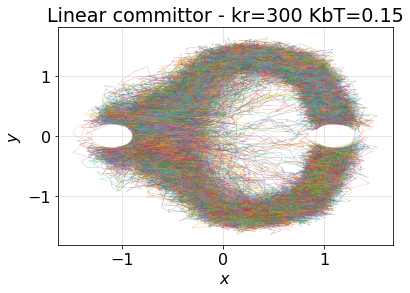

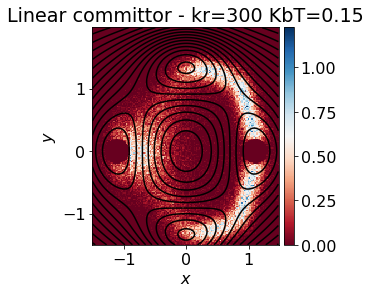

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 310:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


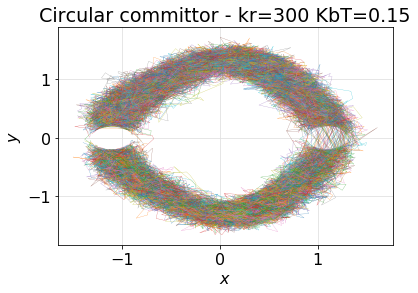

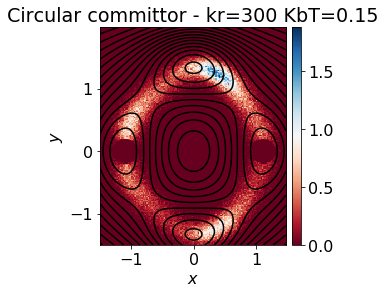

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 310:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


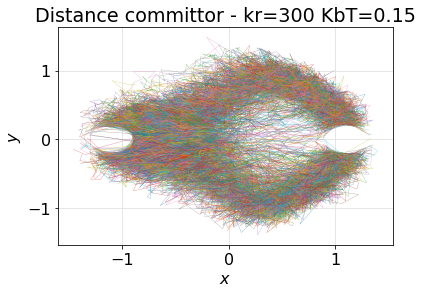

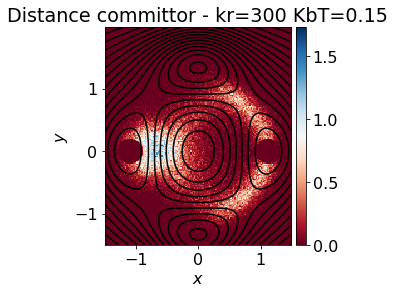

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 310:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


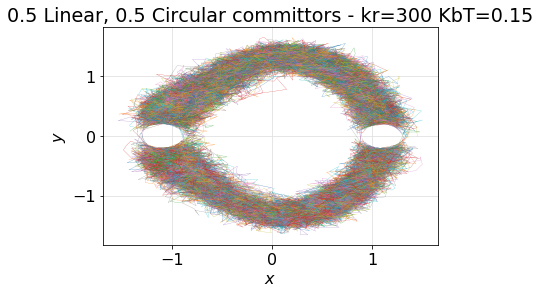

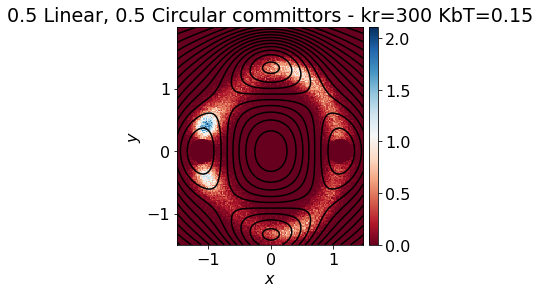

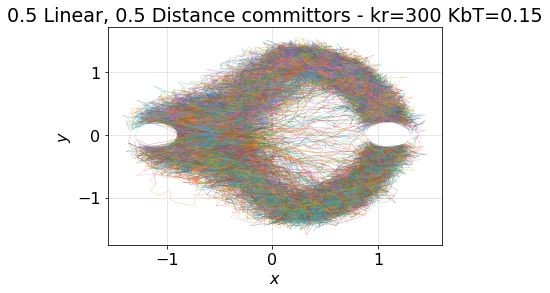

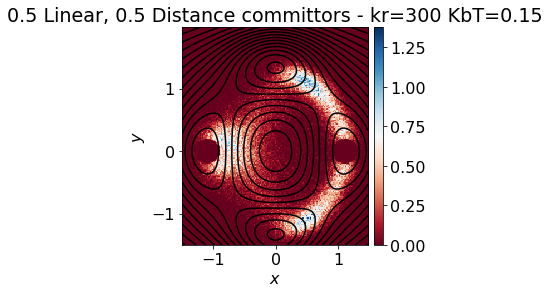

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 310:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, q0 = None,c = [0.5,0.5], R =0.2, dt = 0.02, KbT = 0.15, kr = 300, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


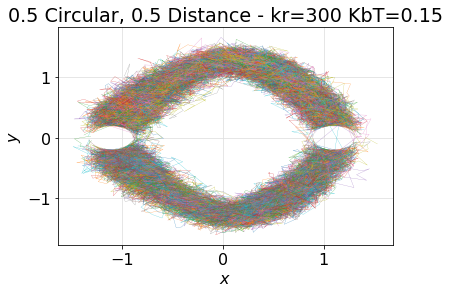

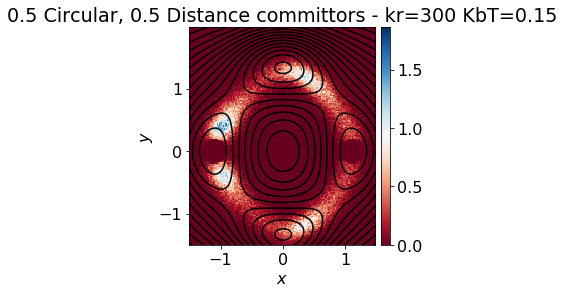

In [8]:
### Linear committor

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = [1.0, 0.0])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("Linear committor - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("Linear committor - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

### Circular committor

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCircle, dGuess1 = dqCircle, Guess2 = qCircle, dGuess2 = dqCircle, kr = KR, KbT = KBT, c = [1.0, 0.0])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("Circular committor - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

## Density plot of how much time the system passes in a given point
# Borders of the plot
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("Circular committor - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

### Distance committor

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qDist, dGuess1 = dqDist, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = [1.0, 0.0])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("Distance committor - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("Distance committor - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

### Linear/circular committor

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircle, dGuess2 = dqCircle, kr = KR, KbT = KBT, c = [0.5, 0.5])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("0.5 Linear, 0.5 Circular committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("0.5 Linear, 0.5 Circular committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

### Linear/distance committor

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = [0.5, 0.5])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("0.5 Linear, 0.5 Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("0.5 Linear, 0.5 Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

### Circular/distance committor

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCircle, dGuess1 = dqCircle, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = [0.5, 0.5])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("0.5 Circular, 0.5 Distance - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("0.5 Circular, 0.5 Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Now we do the self consistent procedure

In [9]:
KR = 300
KBT = 0.15

Cycle =  1
Cycle =  2
Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30


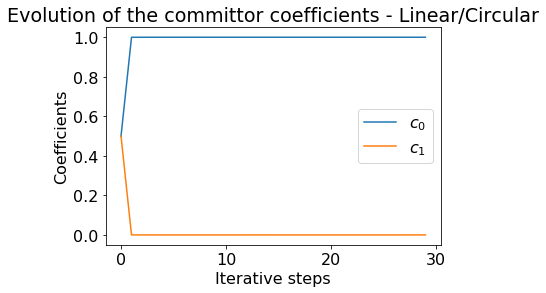

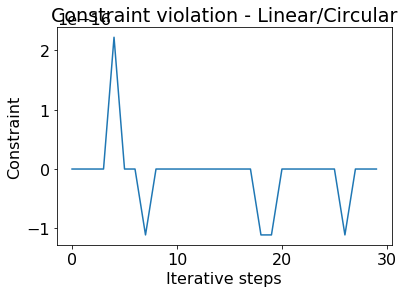

Final coefficients - Linear/Circular
[9.99806864e-01 1.93136146e-04]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 38:
@njit(fastmath=True)
def qLin(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircle'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 99:
@njit(fastmath=True)


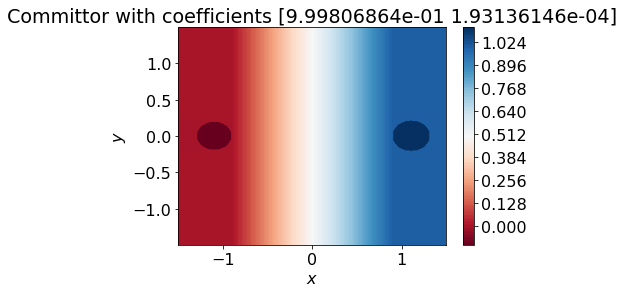

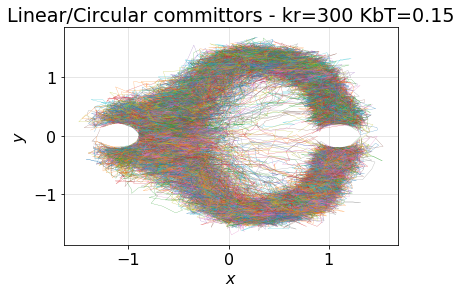

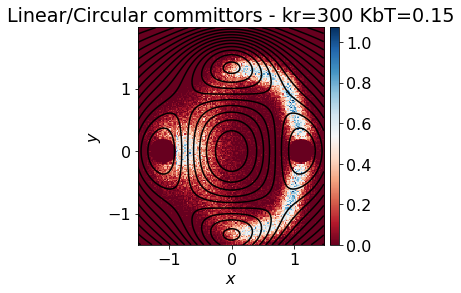

In [10]:
### Linear/circular coefficient
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M
# Self consistent procedure
c = Self_consistent(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircle, dGuess2 = dqCircle, kr = KR, KbT = KBT, c = [0.5, 0.5])
# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
plt.plot(c[:,0], label = r"$c_0$")
plt.plot(c[:,1], label = r"$c_1$")
plt.title("Evolution of the committor coefficients - Linear/Circular")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure()
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation - Linear/Circular")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients - Linear/Circular")
print(c[-1,:])
comm_plot(Guess1 = qLin, Guess2 = qCircle, c = c[-1,:])

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qCircle, dGuess2 = dqCircle, kr = KR, KbT = KBT, c = c[-1,:])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("Linear/Circular committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("Linear/Circular committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Cycle =  1
Cycle =  2
Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30


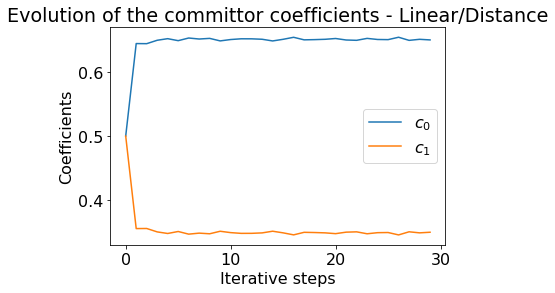

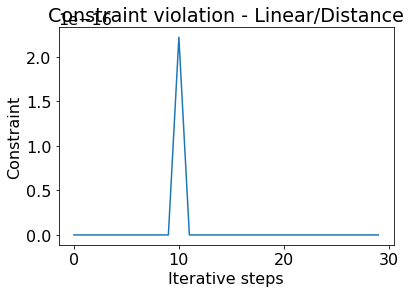

Final coefficients - Linear/Distance
[0.64944006 0.35055994]
[0.42177239 0.12289227]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qDist'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-5fb359ca1e13>", line 195:
@njit(fastmath=True)
def qDist(q, R=0.2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


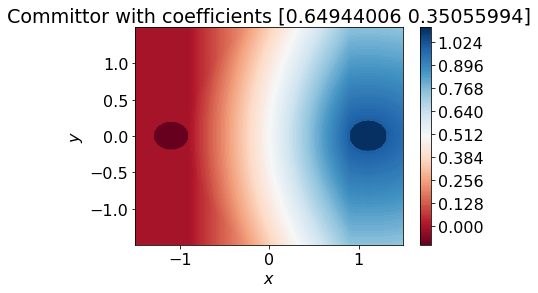

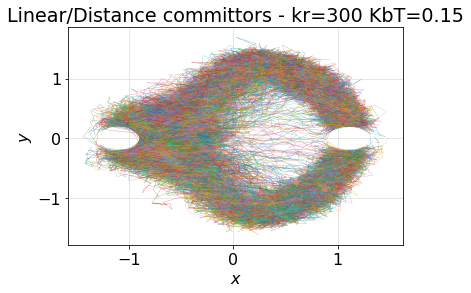

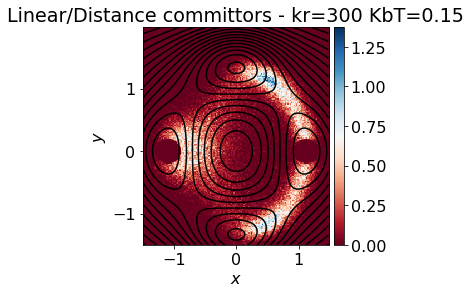

In [11]:
### Linear/distance coefficient
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M
# Self consistent procedure
c = Self_consistent(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = [0.5, 0.5])
# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
plt.plot(c[:,0], label = r"$c_0$")
plt.plot(c[:,1], label = r"$c_1$")
plt.title("Evolution of the committor coefficients - Linear/Distance")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure()
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation - Linear/Distance")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients - Linear/Distance")
print(c[-1,:])
# Print the corresponding committor
print(c[-1,:]**2)
comm_plot(Guess1 = qLin, Guess2 = qDist, c = c[-1,:])

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = c[-1,:])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("Linear/Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("Linear/Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Cycle =  1
Cycle =  2
Cycle =  3
Cycle =  4
Cycle =  5
Cycle =  6
Cycle =  7
Cycle =  8
Cycle =  9
Cycle =  10
Cycle =  11
Cycle =  12
Cycle =  13
Cycle =  14
Cycle =  15
Cycle =  16
Cycle =  17
Cycle =  18
Cycle =  19
Cycle =  20
Cycle =  21
Cycle =  22
Cycle =  23
Cycle =  24
Cycle =  25
Cycle =  26
Cycle =  27
Cycle =  28
Cycle =  29
Cycle =  30


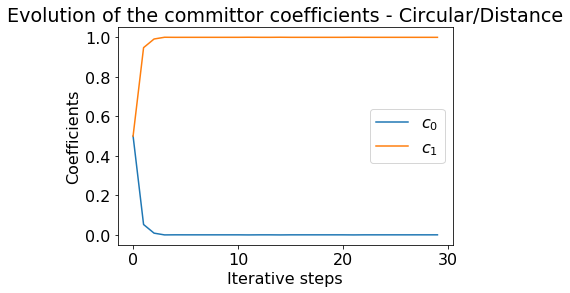

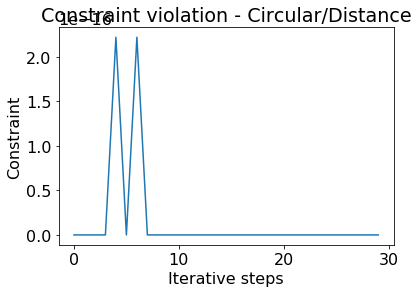

Final coefficients - Circular/Distance
[5.41176600e-04 9.99458823e-01]


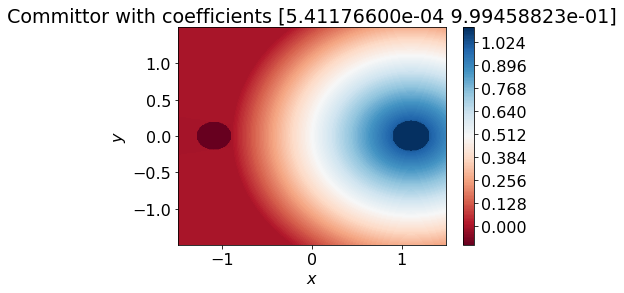

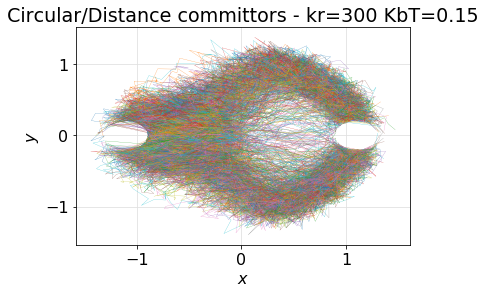

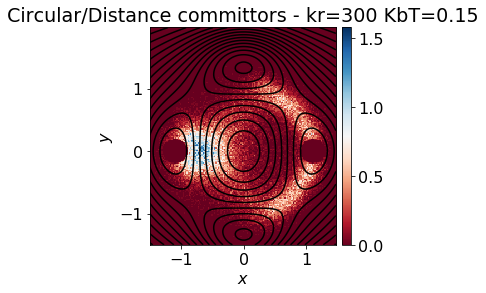

In [12]:
### Circular/Distance coefficient
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M
# Self consistent procedure
c = Self_consistent(Guess1 = qCircle, dGuess1 = dqCircle, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = [0.5, 0.5])
# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure()
plt.plot(c[:,0], label = r"$c_0$")
plt.plot(c[:,1], label = r"$c_1$")
plt.title("Evolution of the committor coefficients - Circular/Distance")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure()
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation - Circular/Distance")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients - Circular/Distance")
print(c[-1,:])
comm_plot(Guess1 = qCircle, Guess2 = qDist, c = c[-1,:])

## Runs of the Langevin dynamics
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCircle, dGuess1 = dqCircle, Guess2 = qDist, dGuess2 = dqDist, kr = KR, KbT = KBT, c = c[-1,:])
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title("Circular/Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
xedges = np.arange(-1.5, 1.5, 0.02).tolist()
yedges = np.arange(-1.5, 2.0, 0.02).tolist()
# Load the data
x = trajall[:,0]
y = trajall[:,1]
# Create the histogram
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
# contour lines
x = np.arange(-1.5, 1.5, 0.025)
y = np.arange(-1.5, 2.0, 0.025)
X, Y = np.meshgrid(x, y)
# Identity matrix
I = X*0+1
# Probability of the 
U1 = u0*(np.exp(-(X**2 + Y**2)) - 4.0/3.0*np.exp(-(X**2 + (Y - b0*I)**2)) - 4.0/3.0*np.exp(-(X**2 + (Y + b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4 + (Y + a0*I)**4)
Z = np.exp(-KBT*(U1 + U2))
CS = plt.contour(X, Y, Z, 15, colors='k')
# labels and title
plt.title("Circular/Distance committors - kr="+str(KR)+" KbT="+str(KBT))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()